# Data preparation of labels from manual labeling and reviewing process

of the sampled crashes

In [ ]:
# import importlib
# importlib.reload(config)
# import utils.config as config

In [15]:
import pandas as pd
import utils.config as config
import numpy as np

# manually labeled
df_mlerr_labels = pd.read_excel(config.path_default.joinpath('Manual_labeing/cluster_sampled_labeled.xlsx'),
                                sheet_name = "Del-All",
                                keep_default_na=False)

df_mlerr_label_config = pd.read_excel(config.path_default.joinpath('Manual_labeing/cluster_sampled_labeled.xlsx'),
                                sheet_name = "Config",
                                keep_default_na=False)
df_mlerr_label_config_exclude = ["Review_res", "Responsible"]
df_mlerr_label_config.drop(df_mlerr_label_config_exclude, axis=1, inplace=True)
df_mlerr_labels['other'].replace([0], "", inplace=True)

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [17]:
# labels in the config but are not used in manual labeling
for label_key in df_mlerr_label_config:
    print(label_key)
    print([i for i in df_mlerr_label_config[label_key].unique() if i not in df_mlerr_labels[label_key].unique()])
    
    updated_config = [i for i in df_mlerr_label_config[label_key].unique() if i in df_mlerr_labels[label_key].unique()]
    for _ in range(len(df_mlerr_label_config)-len(updated_config)):
        updated_config.append(np.nan)
    for _ in range(len(updated_config)-len(df_mlerr_label_config)):
        df_mlerr_label_config.loc[len(df_mlerr_label_config)] = pd.Series(dtype='float64')
    
    df_mlerr_label_config[label_key] = updated_config

label_root_cause
['intentional', '']
label_ML_pipeline
['not-applicable (sub-labels needed, e.g., tutorials, physics simulation, ..)', 'unknown', 'not applicable - tutorial notebook', 'not applicable - physics', 'not applicable - education', '']
label_if_ML_bug
['unknown', '']
label_refined_exp_type
['constraint violation (database)']
label_if_runinfo_help
['']
label_if_code_error_align
['']
label_if_error_chain
['unknown', '']
other
['intentional', 'should exclude']


In [18]:
# labels used in manual labeling but not in config !!should not happen!!
for label_key in df_mlerr_label_config:
    print(label_key)
    print([i for i in df_mlerr_labels[label_key].unique() if i not in df_mlerr_label_config[label_key].unique()])

label_root_cause
[]
label_ML_pipeline
[]
label_if_ML_bug
[]
label_refined_exp_type
[]
label_if_runinfo_help
[]
label_if_code_error_align
[]
label_if_error_chain
[]
other
[]


In [19]:
# need to take care of n/a in df_mlerr_label_config (label_refined_exp_type)
# it means the same as the enames

df_mlerr_labels['label_refined_exp_type'] = np.where(df_mlerr_labels['label_refined_exp_type'] == 'n/a', 
                                                     df_mlerr_labels['ename'], 
                                                     df_mlerr_labels['label_refined_exp_type'])
real_refined_exp_types = set(df_mlerr_label_config.label_refined_exp_type).union(set(df_mlerr_labels['label_refined_exp_type'].unique()))
real_refined_exp_types.remove("n/a")
real_refined_exp_types.remove(np.nan)
real_refined_exp_types=list(real_refined_exp_types)
for _ in range(len(df_mlerr_label_config)-len(real_refined_exp_types)):
    real_refined_exp_types.append(np.nan)
for _ in range(len(real_refined_exp_types)-len(df_mlerr_label_config)):
    df_mlerr_label_config.loc[len(df_mlerr_label_config)] = pd.Series(dtype='float64')

df_mlerr_label_config['label_refined_exp_type'] = list(real_refined_exp_types)

In [20]:
assert(df_mlerr_labels.label_refined_exp_type.nunique()==len(df_mlerr_label_config.label_refined_exp_type))
df_mlerr_label_config.to_excel(config.path_default.joinpath("Manual_labeing/cluster_sampled_labeled_config.xlsx"), index=False, engine='xlsxwriter')

Map the summarized config to config and the data

In [23]:
# config
df_mlerr_label_config_sum = df_mlerr_label_config.copy()
for summed_label_name in config.summed_label_names:
    option_dict = { v: k for k, l in getattr(config, summed_label_name).items() for v in l }
    config_tobe_mapped = df_mlerr_label_config_sum[summed_label_name]
    list_mapped = set(["" if (pd.isnull(item)|(item=="")) else option_dict[item] for item in config_tobe_mapped])
    list_mapped = list(filter(None, list_mapped))
    list_mapped.extend([""]*(len(config_tobe_mapped)-len(list_mapped)))
    df_mlerr_label_config_sum[summed_label_name] = list_mapped
df_mlerr_label_config_sum.to_excel(config.path_default.joinpath("Manual_labeing/cluster_sampled_labeled_config_sum.xlsx"), index=False, engine='xlsxwriter')

# data
df_mlerr_labels_sum = df_mlerr_labels.copy()
for summed_label_name in config.summed_label_names:
    option_dict = { v: k for k, l in getattr(config, summed_label_name).items() for v in l }
    df_mlerr_labels_sum[summed_label_name] = ["" if (pd.isnull(item)|(item=="")) else option_dict[item] for item in df_mlerr_labels_sum[summed_label_name]]
df_mlerr_labels_sum.to_excel(config.path_default.joinpath("Manual_labeing/cluster_sampled_labeled_sum.xlsx"), index=False, engine='xlsxwriter')

# Visualization

In [21]:
# plot settings
import utils.Mycolor as Mycolor
import matplotlib.pyplot as plt
import numpy as np

mycolor = Mycolor.Mycolor()
cm = mycolor.cm
cm_2 = mycolor.cm_2
cm_3 = mycolor.cm_3
cm_dp = mycolor.cm_dp

# some other settings
rc2abbr = {"API":"API","NB specific":"NB","data":"DATA","environment":"ENV","implementation":"IMPL",
           "library":"LIB","resources":"RSC","unknown":"UNK"}
mlpp2abbr = {'environment setup':"ENVS", 'data preparation':"DATAP", 'data visualization':"DATAV",
             'model construction':"MCONS", 'training':"MTRAIN", 'evaluation/prediction':"EVAL"}
order_mlpp = ["environment setup", "data preparation", "data visualization", "model construction", "training", "evaluation/prediction"]

In [1]:
# prepare data

import pandas as pd
import utils.config as config
import utils.visualization_util as visualization_util

# original data and config
df_mlerr_label_config = pd.read_excel(config.path_default.joinpath('Manual_labeing/cluster_sampled_labeled_config.xlsx'),
                                keep_default_na=False)
exclude_config = ["label_if_error_chain"] # because it is the same as root cause==nb specific-previous cell error
df_mlerr_label_config.drop(exclude_config, axis=1, inplace=True)
# data
df_mlerr_labels = pd.read_excel(config.path_default.joinpath('Manual_labeing/cluster_sampled_labeled.xlsx'),
                                sheet_name = "Del-All",
                                keep_default_na=False)
df_mlerr_labels_g = df_mlerr_labels[df_mlerr_labels["nb_source"]==config.NB_SOURCE["github"]].reset_index(drop=True)
df_mlerr_labels_k = df_mlerr_labels[df_mlerr_labels["nb_source"]==config.NB_SOURCE["kaggle"]].reset_index(drop=True)
del df_mlerr_labels

print(df_mlerr_labels_g.eid.nunique())
print(df_mlerr_labels_k.eid.nunique())

# summed data and config
# config
df_mlerr_label_config_sum = pd.read_excel(config.path_default.joinpath('Manual_labeing/cluster_sampled_labeled_config_sum.xlsx'),
                                keep_default_na=False)
exclude_config = ["label_if_error_chain"] # because it is the same as root cause==nb specific-previous cell error
df_mlerr_label_config_sum.drop(exclude_config, axis=1, inplace=True)
# data
df_mlerr_labels_sum = pd.read_excel(config.path_default.joinpath('Manual_labeing/cluster_sampled_labeled_sum.xlsx'))
df_mlerr_labels_g_sum = df_mlerr_labels_sum[df_mlerr_labels_sum["nb_source"]==config.NB_SOURCE["github"]].reset_index(drop=True)
df_mlerr_labels_k_sum = df_mlerr_labels_sum[df_mlerr_labels_sum["nb_source"]==config.NB_SOURCE["kaggle"]].reset_index(drop=True)
del df_mlerr_labels_sum

print(df_mlerr_labels_g_sum.eid.nunique())
print(df_mlerr_labels_k_sum.eid.nunique())

# Summarize the statistics based on - df_mlerr_labels_sum
# github stats
cluster_res_g_sum = visualization_util.statistics_labels(df_mlerr_label_config_sum, df_mlerr_labels_g_sum)
for label_key in df_mlerr_label_config_sum:
    cluster_res_g_sum[label_key] = pd.DataFrame.from_dict(cluster_res_g_sum[label_key]).rename_axis('cluster_id').reset_index()
# for all clusters    
cluster_res_g_sum_weighted_sum = visualization_util.cal_weighted_sum(df_mlerr_label_config_sum, cluster_res_g_sum)

# kaggle stats
cluster_res_k_sum = visualization_util.statistics_labels(df_mlerr_label_config_sum, df_mlerr_labels_k_sum)
for label_key in df_mlerr_label_config_sum:
    cluster_res_k_sum[label_key] = pd.DataFrame.from_dict(cluster_res_k_sum[label_key]).rename_axis('cluster_id').reset_index()
cluster_res_k_sum_weighted_sum = visualization_util.cal_weighted_sum(df_mlerr_label_config_sum, cluster_res_k_sum)

path_default=WindowsPath('C:/Users/yirwa29/Downloads/data_jupyter_nbs_empirical')


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


390
356
390
356


### rq1: What are the prevalent exception types and root causes in ML notebooks?

In [3]:
# exception types
# top 10 + other (remainings)

cluster_res_exp_type_sum_weighted_sum = {x: cluster_res_k_sum_weighted_sum['label_refined_exp_type'].get(x, 0) + cluster_res_g_sum_weighted_sum['label_refined_exp_type'].get(x, 0)
                                         for x in set(cluster_res_k_sum_weighted_sum['label_refined_exp_type']).union(cluster_res_g_sum_weighted_sum['label_refined_exp_type'])}
df_cluster_res_exp_type_sum = pd.DataFrame(cluster_res_exp_type_sum_weighted_sum, index=["Combined"]).T.sort_values(by="Combined", ascending=False)
include_num = 10
df_cluster_res_exp_type_other = pd.DataFrame(df_cluster_res_exp_type_sum[include_num:].sum(axis=0)).T.rename(index={0: "other"})
df_cluster_res_exp_type_sum = pd.concat([df_cluster_res_exp_type_sum[:include_num], df_cluster_res_exp_type_other])

df_cluster_res_exp_type_kg = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_refined_exp_type'],
                   cluster_res_g_sum_weighted_sum['label_refined_exp_type']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})

df_cluster_res_exp_type_kg_other = pd.DataFrame(df_cluster_res_exp_type_kg[~df_cluster_res_exp_type_kg.index.isin(df_cluster_res_exp_type_sum.index[:include_num])].sum(axis=0)).T.rename(index={0: "other"})
df_cluster_res_exp_type_kg = pd.concat([df_cluster_res_exp_type_kg.loc[df_cluster_res_exp_type_sum.index[:include_num].to_list()], df_cluster_res_exp_type_kg_other])
df_cluster_res_exp_type_kg = pd.concat([df_cluster_res_exp_type_sum, df_cluster_res_exp_type_kg], axis=1)
df_cluster_res_exp_type_kg.loc['total']= df_cluster_res_exp_type_kg.sum()

df_cluster_res_exp_type_kg.index.name = "Exception type"
df_cluster_res_exp_type_kg[["Combined","GitHub","Kaggle"]]

,Combined,GitHub,Kaggle
Exception type,,,
name,222,121,101
value,131,63,68
API arg,73,40,33
io,71,34,37
attribute,52,29,23
key,50,21,29
type,40,24,16
index,29,17,12
resource,17,6,11


In [4]:
# transform to percentages
exp_plot = df_cluster_res_exp_type_kg.copy()
exp_plot.loc[:,'Kaggle']=(df_cluster_res_exp_type_kg['Kaggle']/df_cluster_res_exp_type_kg[:-1]['Kaggle'].sum()*100).round(2)
exp_plot.loc[:,'GitHub']=(df_cluster_res_exp_type_kg['GitHub']/df_cluster_res_exp_type_kg[:-1]['GitHub'].sum()*100).round(2)
exp_plot = exp_plot[:-1][["GitHub","Kaggle"]]

C:\Users\yirwa29\AppData\Local\Temp\ipykernel_26444\1978658013.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 28.37  19.1    9.27  10.39   6.46   8.15   4.49   3.37   3.09   2.25
   5.06 100.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  exp_plot.loc[:,'Kaggle']=(df_cluster_res_exp_type_kg['Kaggle']/df_cluster_res_exp_type_kg[:-1]['Kaggle'].sum()*100).round(2)
C:\Users\yirwa29\AppData\Local\Temp\ipykernel_26444\1978658013.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 31.03  16.15  10.26   8.72   7.44   5.38   6.15   4.36   1.54   2.31
   6.67 100.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  exp_plot.loc[:,'GitHub']=(df_cluster_res_exp_type_kg['GitHub']/df_cluster_res_exp_type_kg[:-1]['GitHub'].sum()*100).round(2)


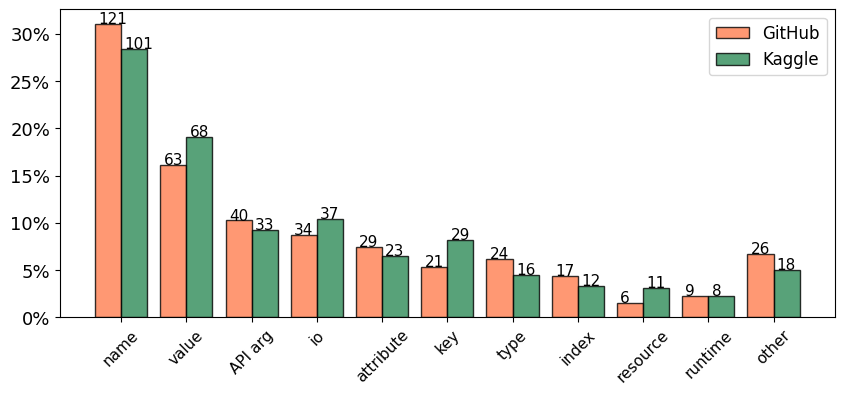

In [5]:
from matplotlib.ticker import PercentFormatter

# plot
ind = np.arange(len(exp_plot.index))

width = 0.4
fontsize = 16
fig = plt.figure(figsize=(10,4))
bars = plt.bar(ind - width / 2, exp_plot.GitHub, width, label = 'GitHub', alpha = 0.8, color = 'coral', edgecolor = 'black')
for id_bar in range(len(bars)):
    bar = bars[id_bar]
    plt.text(bar.get_x()+.05, bar.get_height()+.05, df_cluster_res_exp_type_kg.GitHub.iloc[id_bar], fontsize=11)
bars = plt.bar(ind + width / 2, exp_plot.Kaggle, width, label = 'Kaggle', alpha = 0.8, color = 'seagreen', edgecolor = 'black')
for id_bar in range(len(bars)):
    bar = bars[id_bar]
    plt.text(bar.get_x()+.05, bar.get_height()+.05, df_cluster_res_exp_type_kg.Kaggle.iloc[id_bar], fontsize=11)

# x ticks
plt.xticks(ind, exp_plot.index, rotation=45, fontsize=fontsize-5)
plt.yticks(fontsize=fontsize-3)

fig.axes[0].yaxis.set_major_formatter(PercentFormatter(decimals=0))
    
# original legend   
plt.legend(fontsize=fontsize-4) 

# plt.savefig(config.path_default.joinpath('exp.pdf'), bbox_inches='tight')
plt.show()

In [8]:
# root cause
rc = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_root_cause'],
                   cluster_res_g_sum_weighted_sum['label_root_cause']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})

rc.index.name = "Root cause"
rc['Combined'] = rc['Kaggle']+rc['GitHub']
rc = rc.sort_values(by=['Combined'], ascending=False)
rc.loc['total']= rc.sum()
# print((rc['Combined'].loc['API']+rc['Combined'].loc['data']+rc['Combined'].loc['implementation'])/rc['Combined'].loc['total'])
rc[["Combined","GitHub","Kaggle"]]
# (rc/rc[1:].sum()*100).round(2)

,Combined,GitHub,Kaggle
Root cause,,,
API,159,83,76
NB specific,143,75,68
data,138,70,68
environment,125,70,55
implementation,124,67,57
unknown,31,18,13
resources,17,6,11
library,9,1,8
total,746,390,356


In [9]:
# zoom in to root cause == NB specific - xxx
nb_g = df_mlerr_labels_g[df_mlerr_labels_g["label_root_cause"].isin(config.label_root_cause["NB specific"])]
nb_g_counts = nb_g.groupby("label_root_cause")["label_root_cause"].value_counts().sort_values(ascending=False)
# merge out-of-order implementation into out-of-order execution
nb_g_counts["nb specific - execution order"] = nb_g_counts["nb specific - execution order"]+nb_g_counts["nb specific - need execute future cells"]
nb_g_counts = nb_g_counts[["nb specific - execution order","nb specific - previous cell error"]]
nb_g_counts = (nb_g_counts/nb_g_counts.sum()*100).round(2)
nb_k = df_mlerr_labels_k[df_mlerr_labels_k["label_root_cause"].isin(config.label_root_cause["NB specific"])]
nb_k_counts = nb_k.groupby("label_root_cause")["label_root_cause"].value_counts().sort_values(ascending=False)
nb_k_counts["nb specific - execution order"] = nb_k_counts["nb specific - execution order"]+nb_k_counts["nb specific - need execute future cells"]
nb_k_counts = nb_k_counts[["nb specific - execution order","nb specific - previous cell error"]]
nb_k_counts = (nb_k_counts/nb_k_counts.sum()*100).round(2)

nb_pp = pd.DataFrame([nb_g_counts,nb_k_counts],index=['GitHub','Kaggle'])
nb_pp.columns=["Out-of-order execution", "Previous cell error"] # "Out of order implementation"
nb_pp.index.name = 'NB specific'

nb_pp.T.astype(str) + '%'

NB specific,GitHub,Kaggle
Out-of-order execution,60.0%,75.0%
Previous cell error,40.0%,25.0%


In [10]:
# transform to percentages
rc_plot = rc[:-1].copy()
rc_plot.loc[:,'Kaggle']=(rc['Kaggle']/rc['Kaggle'].sum()*100).round(2)
rc_plot.loc[:,'GitHub']=(rc['GitHub']/rc['GitHub'].sum()*100).round(2)

rc_nb_g = rc_plot.loc["NB specific","GitHub"]
rc_nb_k = rc_plot.loc["NB specific","Kaggle"]
rc_plot.loc["NB specific","GitHub"]=0
rc_plot.loc["NB specific","Kaggle"]=0

C:\Users\yirwa29\AppData\Local\Temp\ipykernel_26444\1976806851.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[10.67  9.55  9.55  7.72  8.01  1.83  1.54  1.12]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rc_plot.loc[:,'Kaggle']=(rc['Kaggle']/rc['Kaggle'].sum()*100).round(2)
C:\Users\yirwa29\AppData\Local\Temp\ipykernel_26444\1976806851.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[10.64  9.62  8.97  8.97  8.59  2.31  0.77  0.13]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  rc_plot.loc[:,'GitHub']=(rc['GitHub']/rc['GitHub'].sum()*100).round(2)


Index(['Out-of-order execution', 'Previous cell error'], dtype='object')


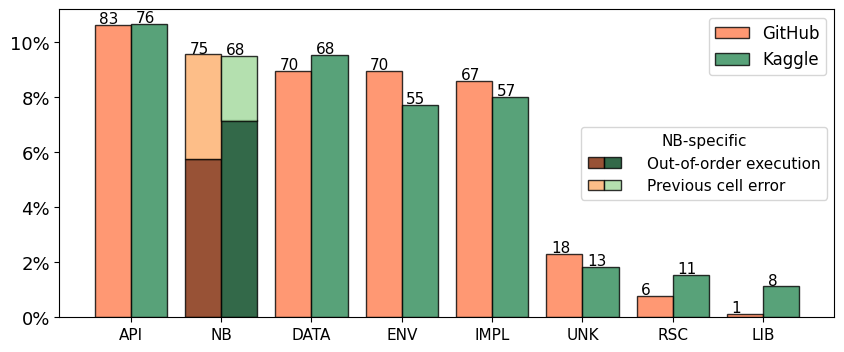

In [11]:
from matplotlib.ticker import PercentFormatter

# plot
ind = np.arange(len(rc_plot.index))

width = 0.4
fontsize = 16
fig = plt.figure(figsize=(10,4))
bars = plt.bar(ind - width / 2, rc_plot.GitHub, width, label = 'GitHub', alpha = 0.8, color = 'coral', edgecolor = 'black')
for id_bar in range(len(bars)):
    bar = bars[id_bar]
    if id_bar==1:
        plt.text(bar.get_x()+.05, rc_nb_g+.0, rc.GitHub.iloc[id_bar], fontsize=11)
        continue
    plt.text(bar.get_x()+.05, bar.get_height()+.05, rc.GitHub.iloc[id_bar], fontsize=11)

bars = plt.bar(ind + width / 2, rc_plot.Kaggle, width, label = 'Kaggle', alpha = 0.8, color = 'seagreen', edgecolor = 'black')
for id_bar in range(len(bars)):
    bar = bars[id_bar]
    if id_bar==1:
        plt.text(bar.get_x()+.05, rc_nb_k+.0, rc.Kaggle.iloc[id_bar], fontsize=11)
        continue
    plt.text(bar.get_x()+.05, bar.get_height()+.05, rc.Kaggle.iloc[id_bar], fontsize=11)


# np specific
npspe_list = nb_pp.T.index
weight_count_g = nb_pp.T["GitHub"]*rc_nb_g/100
weight_count_k = nb_pp.T["Kaggle"]*rc_nb_k/100
bottom_g, bottom_k = 0,0
for i in range(len(npspe_list)):
    plt.bar(1 - width / 2, weight_count_g.iloc[i], width, alpha=0.8, color = cm_2(i*5), edgecolor = 'black',  bottom=bottom_g) 
    bottom_g += weight_count_g.iloc[i]-0.03
    plt.bar(1 + width / 2, weight_count_k.iloc[i], width, alpha=0.8, color = cm(i*5), edgecolor = 'black',  bottom=bottom_k) 
    bottom_k += weight_count_k.iloc[i]-0.03

# x ticks
xticks_labels_new = [rc2abbr[x] for x in rc_plot.index]
plt.xticks(ind, xticks_labels_new, rotation=0, fontsize=fontsize-5)
plt.yticks(fontsize=fontsize-3)

fig.axes[0].yaxis.set_major_formatter(PercentFormatter(decimals=0))
# plt.xlabel("Exception types", fontsize=fontsize) 
# plt.ylabel("Percentage of errors", fontsize=fontsize) 

# np specific - add another legend
lgd_colors = [cm_2(i*5) for i in range(2)] + [cm(i*5) for i in range(2)]
print(npspe_list)
# legend 2 labels
lgd_labels=[""]*2+["Out-of-order execution", "Previous cell error"] #, "Out-of-order implementation"

lgnd = fig.axes[0].legend(labels=lgd_labels, loc="center right", ncols=2, fontsize=fontsize-5,columnspacing=-1.7, 
                          title="NB-specific", title_fontsize=fontsize-5)
fig.axes[0].add_artist(lgnd)
i=0
for handle in lgnd.legend_handles:
    handle.set_width(12)
    handle.set_color(lgd_colors[i])
    handle.set_edgecolor("black")
    i+=1
        
# original legend   
plt.legend(fontsize=fontsize-4) 

# plt.savefig(config.path_default.joinpath('rc.pdf'), bbox_inches='tight')
plt.show()

### rq2: To what extent are failures in ML/data science notebooks related to ML libraries?

In [14]:
mlbug = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_if_ML_bug'],
                   cluster_res_g_sum_weighted_sum['label_if_ML_bug']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})
mlbug['combined'] = mlbug['Kaggle'] + mlbug['GitHub']
mlbug['combined']=(mlbug['combined']/mlbug['combined'].sum()*100).round(2)
mlbug['Kaggle']=(mlbug['Kaggle']/mlbug['Kaggle'].sum()*100).round(2)
mlbug['GitHub']=(mlbug['GitHub']/mlbug['GitHub'].sum()*100).round(2)

mlbug.index=["ML bug", "Python bug"]
mlbug.index.name = 'If ML bug'
mlbug #[["GitHub","Kaggle"]]

,Kaggle,GitHub,combined
If ML bug,,,
ML bug,72.47,61.03,66.49
Python bug,27.53,38.97,33.51


In [16]:
df_grouped_g = df_mlerr_labels_g_sum.groupby("label_if_ML_bug")["label_root_cause"].value_counts().unstack("label_root_cause")
# df_grouped_g.insert(6, "library", 0)
df_grouped_k = df_mlerr_labels_k_sum.groupby("label_if_ML_bug")["label_root_cause"].value_counts().unstack("label_root_cause")

df_grouped = df_grouped_g + df_grouped_k
df_grouped = (df_grouped.T/df_grouped.sum(axis=1)).fillna(0)
df_grouped_g = (df_grouped_g.T/df_grouped_g.sum(axis=1)).fillna(0)
df_grouped_k = (df_grouped_k.T/df_grouped_k.sum(axis=1)).fillna(0)

df_grouped_g = df_grouped_g.rename(columns={"python bug": "Python bug"})
df_grouped_k = df_grouped_k.rename(columns={"python bug": "Python bug"})
df_grouped = df_grouped.rename(columns={"python bug": "Python bug"})

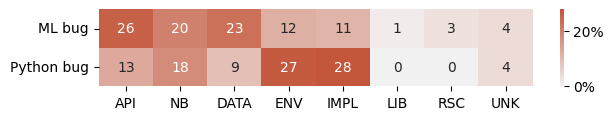

In [17]:
import seaborn as sns

# plot the heatmap for the combined dataset, rc and mlbug relationship in percentages
f,(ax1) = plt.subplots(1, 1, figsize=(7, 1))
rc_new = [rc2abbr[x] for x in df_grouped.index]
s = sns.heatmap((df_grouped*100).round(0).astype(int).T, fmt = "d", cbar_kws={'format': '%d%%'},
                annot=True, xticklabels=rc_new, 
                cmap=cm_dp,# "vlag", 
                center=0, #vmin=0, vmax=25,
                ax=ax1)
s.set(xlabel='', ylabel='')

# f.savefig(config.path_default.joinpath('mlbug_rc.pdf'), bbox_inches='tight')
plt.show()

### rq3: In which phases of ML development in notebooks are exceptions most likely to occur? 

In [22]:
df_mlpp = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_ML_pipeline'],
                     cluster_res_g_sum_weighted_sum['label_ML_pipeline']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})
df_mlpp.index.name = "ML pipeline"
df_mlpp = df_mlpp.reindex(order_mlpp)
df_mlpp.loc['total']= df_mlpp.sum()
df_mlpp['combined'] = df_mlpp['Kaggle']+df_mlpp['GitHub']
df_mlpp

,Kaggle,GitHub,combined
ML pipeline,,,
environment setup,19,36,55
data preparation,99,147,246
data visualization,46,53,99
model construction,35,28,63
training,77,69,146
evaluation/prediction,80,57,137
total,356,390,746


In [23]:
# data prepare
# ml pipeline distribution
mlpp_raw = pd.DataFrame([cluster_res_k_sum_weighted_sum['label_ML_pipeline'],
                         cluster_res_g_sum_weighted_sum['label_ML_pipeline']]).T.rename(columns={0: 'Kaggle', 1: 'GitHub'})
mlpp = mlpp_raw.copy()
mlpp['Kaggle']=(mlpp_raw['Kaggle']/mlpp_raw['Kaggle'].sum()*100).round(2)
mlpp['GitHub']=(mlpp_raw['GitHub']/mlpp_raw['GitHub'].sum()*100).round(2)
mlpp = mlpp.reindex(order_mlpp)
mlpp_raw = mlpp_raw.reindex(order_mlpp)

# ml bug distribution for each pipeline
nb_mlpp_mlbug_g = df_mlerr_labels_g_sum.groupby("label_ML_pipeline")["label_if_ML_bug"].value_counts().unstack("label_if_ML_bug").T
nb_mlpp_mlbug_g.index = nb_mlpp_mlbug_g.index+"(GitHub)"
nb_mlpp_mlbug_k = df_mlerr_labels_k_sum.groupby("label_ML_pipeline")["label_if_ML_bug"].value_counts().unstack("label_if_ML_bug").T
nb_mlpp_mlbug_k.index = nb_mlpp_mlbug_k.index+"(Kaggle)"
# nb_mlpp_mlbug = pd.concat([nb_mlpp_mlbug_g, nb_mlpp_mlbug_k], axis=0)
nb_mlpp_mlbug_g_percent = (nb_mlpp_mlbug_g/nb_mlpp_mlbug_g.sum()).round(4)[order_mlpp]
nb_mlpp_mlbug_k_percent = (nb_mlpp_mlbug_k/nb_mlpp_mlbug_k.sum()).round(4)[order_mlpp]

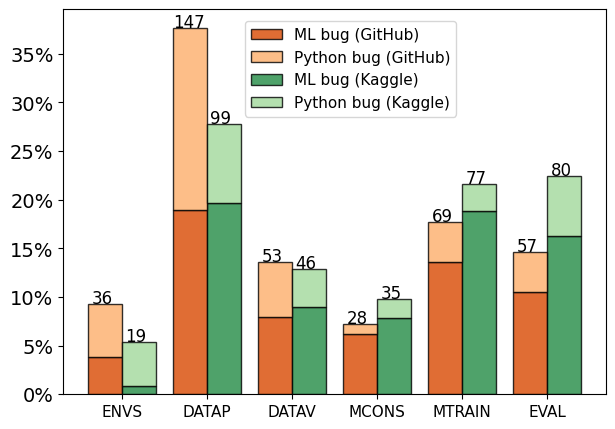

In [24]:
import numpy as np

def plot_mlpp_mlbug(mlpp, mlpp_raw, nb_mlpp_mlbug_g_percent, nb_mlpp_mlbug_k_percent, if_save = False, save_name="mlpp_mlbug.pdf"):
    # plot
    inds = np.arange(len(mlpp.index))

    width = 0.4
    fontsize = 16
    fig = plt.figure(figsize=(7,5))

    weight_count_g = (mlpp["GitHub"] * nb_mlpp_mlbug_g_percent)
    weight_count_k = (mlpp["Kaggle"] * nb_mlpp_mlbug_k_percent)

    bars_g = []
    bars_k = []
    for ind in inds:
        bottom_g, bottom_k = 0,0
        for i in range(max(len(nb_mlpp_mlbug_g_percent.index),len(nb_mlpp_mlbug_k_percent.index))):
            wg = weight_count_g[mlpp.index[ind]]
            if i < len(wg.index):
                bar_g = plt.bar(ind - width / 2, wg.iloc[i], width, alpha=0.8, color = cm_2(i*3+2), edgecolor = 'black',  bottom=bottom_g) 
                bottom_g += wg.iloc[i]
            wk = weight_count_k[mlpp.index[ind]]
            if i < len(wk.index):
                bar_k = plt.bar(ind + width / 2, wk.iloc[i], width, alpha=0.8, color = cm(i*3+2), edgecolor = 'black',  bottom=bottom_k) 
                bottom_k += wk.iloc[i]
        bars_g.append(bar_g)
        bars_k.append(bar_k)

    for id_bar in range(len(bars_g)):
        bar_g = bars_g[id_bar][0]
        bar_k = bars_k[id_bar][0]
        adjust_x = .04
        if mlpp_raw.GitHub.iloc[id_bar]>99:
            adjust_x = .0
        plt.text(bar_g.get_x()+adjust_x, mlpp.GitHub.iloc[id_bar]+.08, mlpp_raw.GitHub.iloc[id_bar], fontsize=fontsize-4)
        adjust_x = .04
        if mlpp_raw.Kaggle.iloc[id_bar]>99:
            adjust_x = .0
        plt.text(bar_k.get_x()+adjust_x, mlpp.Kaggle.iloc[id_bar]+.08, mlpp_raw.Kaggle.iloc[id_bar], fontsize=fontsize-4)

    fig.axes[0].yaxis.set_major_formatter(PercentFormatter(decimals=0))
    xticks_labels = [mlpp2abbr[x] for x in mlpp.index]
    plt.xticks(inds, xticks_labels, rotation=0, fontsize=fontsize-5)
    plt.yticks(fontsize=fontsize-2)

    # legend
    lgd_colors = [cm_2(i*3+2) for i in range(2)] + [cm(i*3+2) for i in range(2)]
    lgd_labels=["ML bug (GitHub)", "Python bug (GitHub)", "ML bug (Kaggle)", "Python bug (Kaggle)"]

    # lgnd = plt.legend(lgd_labels, loc="upper center", ncols=2, fontsize=fontsize-5, columnspacing=0.5)
    lgnd = plt.legend(lgd_labels, bbox_to_anchor=(0.53, 0.845), loc="center", frameon=True, ncols=1, fontsize=fontsize-5, columnspacing=0.5)

    i=0
    for handle in lgnd.legend_handles:
    #     handle.set_width(11)
        handle.set_color(lgd_colors[i])
        handle.set_edgecolor("black")
        i+=1 

    if if_save:
        plt.savefig(config.path_default.joinpath("{}".format(save_name)), bbox_inches='tight')
    plt.show()
    return weight_count_g, weight_count_k
    
weight_count_g, weight_count_k = plot_mlpp_mlbug(mlpp, mlpp_raw, nb_mlpp_mlbug_g_percent, nb_mlpp_mlbug_k_percent, 
                                                 if_save = False, save_name="mlpp_mlbug1.pdf")

In [26]:
# rc distribution for each pipeline

nb_mlpp_rc_g = df_mlerr_labels_g_sum.groupby("label_ML_pipeline")["label_root_cause"].value_counts().unstack("label_root_cause").T
nb_mlpp_rc_k = df_mlerr_labels_k_sum.groupby("label_ML_pipeline")["label_root_cause"].value_counts().unstack("label_root_cause").T

nb_mlpp_rc_g = nb_mlpp_rc_g.fillna(0)
nb_mlpp_rc_k = nb_mlpp_rc_k.fillna(0)
nb_mlpp_rc = nb_mlpp_rc_g + nb_mlpp_rc_k

nb_mlpp_rc_percent = (nb_mlpp_rc/nb_mlpp_rc.sum())[order_mlpp].fillna(0)

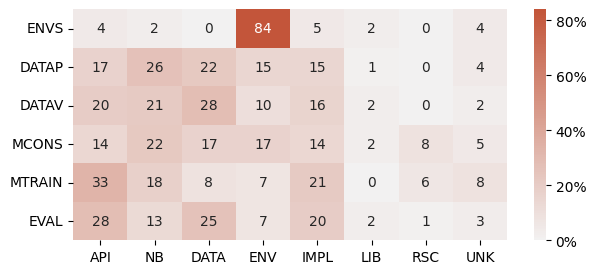

In [27]:
f,(ax1) = plt.subplots(1, 1, figsize=(7, 3))
# ax1.get_shared_y_axes().join(ax2)
rc_new = [rc2abbr[x] for x in nb_mlpp_rc_percent.index]
mlpp_new = [mlpp2abbr[x] for x in nb_mlpp_rc_percent.columns]
s = sns.heatmap((nb_mlpp_rc_percent*100).round(0).astype(int).T, fmt = "d", cbar_kws={'format': '%d%%'},
                annot=True, xticklabels=rc_new, yticklabels=mlpp_new,
                cmap=cm_dp,# "vlag", 
                center=0, #vmin=0, vmax=50,
                ax=ax1)
s.set(xlabel='', ylabel='')
# plt.savefig(config.path_default.joinpath('mlpp_rc.pdf'), bbox_inches='tight')
plt.show()